In [1]:
import pypsa
import pandas as pd
import numpy as np
import os
import pypsatopo

In [286]:
solver = "cbc"

In [288]:
# Create empty PyPSA network
n = pypsa.Network()

In [289]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2019", "01-01-2020", freq="h", inclusive="left")
n.set_snapshots(snapshots)

In [292]:
# To calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

In [294]:
#Removal of certain components

#n.remove(class_name="Link", name="electricity_flow")
#n.remove(class_name="Bus", name="electricity_storage")

<Axes: xlabel='snapshot'>

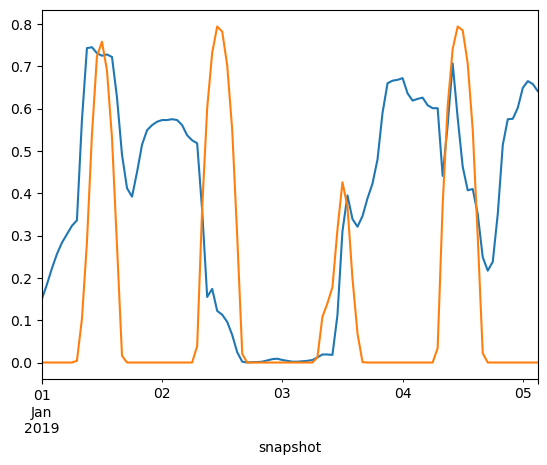

In [452]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv("/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LiNi_Chaoyang_wind_41.6807_120.7899_2.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern), index=n.snapshots)

# Import an example of solar daily pattern
solar_pattern = pd.read_csv("/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LiNi_Chaoyang_pv_41.6807_120.7899.csv")["daily pattern"]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern), index=n.snapshots)

# Import an example of wind daily pattern
#load_pattern = pd.read_csv("/Users/philip/Downloads/2024-10-PyPSA-H2-Training/data/weather data/example_industrial_h2_demand_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
#load_profile = pd.Series(list(load_pattern)*365, index=n.snapshots)

# Print first few values to verify
wind_profile.head(100).plot()
solar_profile.head(100).plot()

In [454]:
# create the buses needed for the ammonia system
n.add(class_name="Bus", name="electricity", carrier="electricity", overwrite=True)

#n.add(class_name="Bus", name="electricity_storage", carrier="electricity", overwrite=True)

# hydrogen buses
n.add(class_name="Bus", name="hydrogen", carrier="hydrogen", overwrite=True)
n.add(class_name="Bus", name="hydrogen_storage", carrier="hydrogen", overwrite=True)
# ammonia buses
n.add(class_name="Bus", name="ammonia", carrier="ammonia", overwrite=True)
n.add(class_name="Bus", name="ammonia_storage", carrier="ammonia", overwrite=True)

n.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
hydrogen,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
hydrogen_storage,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
ammonia,1.0,,0.0,0.0,ammonia,,1.0,0.0,inf,PQ,,
ammonia_storage,1.0,,0.0,0.0,ammonia,,1.0,0.0,inf,PQ,,


In [456]:
#create the end demand load for ammonia

#n.remove(class_name="Load", name="hydrogen_load")
n.add(class_name="Load", name="ammonia_load", bus="ammonia", p_set=100, overwrite=True) 
#n.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100, carrier="hydrogen", type="hydrogen_load", overwrite=True)
# or p_set=load_profile
n.loads


,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
ammonia_load,ammonia,,,100.0,0.0,-1.0,True


In [458]:
#exchange rates
eur_to_usd = 1.1
usd_to_cny = 7.0774

# interest rate / discount rate
interest = 0.0563 # according to BOA PTX; original value: 0.05

In [460]:
# create the generators for wind, based on techno-economic parameters
# Onshore Wind's techno-economic parameters are given as:
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 4500 * 1000 / usd_to_cny # $/MW
FOM = 2 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="onshore_wind",
    bus="electricity",
    carrier="wind",
    p_nom_extendable=True,
    p_nom_min=100, # MW
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=wind_profile, 
    overwrite=True
)

Index(['onshore_wind'], dtype='object', name='Generator')

In [462]:
# create the generator for solar, based on techno-economic parameters
# Solar's techno-economic parameters are given as:
lifetime = 25
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 3940 * 1000 / usd_to_cny # $/MW
FOM = 1 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="solar",
    bus="electricity",
    carrier="solar",
    p_nom_extendable=True,
    p_nom_min=50,
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=solar_profile, 
    overwrite=True
)

Index(['solar'], dtype='object', name='Generator')

In [464]:
#create the generator for hybrid supply

#n.add(class_name="Generator", name="hybrid_wind_solar", bus="electricity", carrier="wind", overwrite=True)

n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshore_wind,electricity,PQ,,0.0,0.0,True,100.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solar,electricity,PQ,,0.0,0.0,True,50.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [466]:
# create hydrogen storage tank

#Techno-economic data for hydrogen storage tank
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 59.7 * 1000 # $/MWh (based on H2 compressed storage tank DTU data); original value: 4779.9527
FOM = 0.43 #%/year; unchanged

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
      class_name="Store",
      name="hydrogen_tank",
      type="hydrogen_tank",
      bus="hydrogen_storage",
      carrier="hydrogen",
      capital_cost=annualized_capex + FOM/100 * annualized_capex,
      e_nom_extendable=True,
      e_cyclic=False,
      marginal_cost=1,#$/MWh 
      overwrite=True
)


Index(['hydrogen_tank'], dtype='object')

In [468]:
# create ammonia storage tank
# Ammonia tank's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.0563

CAPEX = 166.8201 * eur_to_usd # $/MWh
FOM = 4.0 # %/year

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name="Store", 
    name="ammonia_tank",
    type="ammonia_tank",
    bus="ammonia_storage", 
    carrier="ammonia",
    e_nom_extendable=True,
#    e_nom_max=5000,
    e_cyclic=False,
#    e_initial=0,
    capital_cost= annualized_capex * FOM/100 * annualized_capex,
    marginal_cost=1, 
    overwrite=True
)

n.stores

,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,...,sign,marginal_cost,marginal_cost_quadratic,marginal_cost_storage,capital_cost,standing_loss,active,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
hydrogen_tank,hydrogen_storage,hydrogen_tank,hydrogen,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,0.0,0.0,5071.388888,0.0,True,0,inf,0.0
ammonia_tank,ammonia_storage,ammonia_tank,ammonia,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,0.0,0.0,9.636523,0.0,True,0,inf,0.0


In [470]:
# Techno-economic parameters of a lithium ion battery storage:

lifetime = 12.5  # years (average: 10-15); https://greencubes.com/in-the-news/why-lithium-is-taking-over-stationary-energy-storage/
interest = 0.0563  # unit: -
CAPEX = 160 * 1000  # $/MW; original: 600 # 80USD / kWh storage (Nov 2024), assuming 2Ah storages. Source: https://www.energy-storage.news/mind-blowing-bids-power-chinas-16gwh-bess-tender-state-owned-firms-market-share/
FOM = 1.5  # $/MW per year (between 1% and 2% of the CAPEX)
VOM = 0  # $/MWh
fuel_cost = 0  # $/MWh_th per unit water consumed
efficiency_store = 0.965  # assuming similar storing and discharging efficiencies #https://blog.discoverbattery.com/understanding-charging
efficiency_dispatch = 0.965  # assuming similar storing and discharging efficiencies

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="StorageUnit",
    name="battery",
    bus="electricity",
    marginal_cost= VOM + fuel_cost,
    capital_cost=annualized_capex + FOM/100 * annualized_capex,
    p_nom_extendable=True,
    efficiency_store=efficiency_store,
    efficiency_dispatch=efficiency_dispatch,
    p_max_pu=1,  # Discharging availability
    p_min_pu=-1,  # Charging availability
    max_hours=2,  # energy-to-power ratio assumption is 2Ah
#    state_of_charge_initial=100,
    overwrite=True
)


#LCOH MAP is behaving in the same way because hydrogen and ammonia storage are cheaper
# set p_min if you want to really use batteries.

Index(['battery'], dtype='object')

In [472]:
#create the links for electrolysers, ammonia synthesis, electricity flow and hydrogen flow
"""
n.add(
    class_name="Link", 
    name="electricity_flow",
    bus0="electricity",
    bus1="electricity_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)
"""
n.add(
    class_name="Link", 
    name="hydrogen_flow",
    bus0="hydrogen",
    bus1="hydrogen_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.add(
    class_name="Link", 
    name="ammonia_flow",
    bus0="ammonia",
    bus1="ammonia_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,
electrolyser,electricity,hydrogen,,Electrolyser,0.590000,True,0,20.0,0.0,0.0,...,0,1,0,0.30,0.30,0.150,1.0,458.677350,,1.000000
haber_bosch,electricity,ammonia,,Haber-Bosch,7.042254,True,0,20.0,0.0,0.0,...,0,1,0,0.13,0.13,0.015,1.0,14.439127,hydrogen,-8.588099
hydrogen_flow,hydrogen,hydrogen_storage,,,1.000000,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.000,1.0,0.000000,,1.000000
ammonia_flow,ammonia,ammonia_storage,,,1.000000,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.000,1.0,0.000000,,1.000000


In [474]:
#create the link for the electrolyser

# Electrolyser's techno-economic parameters are given as:
lifetime = 20
interest = 0.05
#water_cost = 1.8 # EUR/m3_H2O --> this includes the water treatment costs applied to the seawater
#water_demand_ratio= 21 # kgH2O/kgH2 --> how much water is needed to produce 1 kg of hydrogen?

CAPEX = 600.34 # $/MW
FOM = 2 # %/year or CAPEX
VOM = 0 # $/MWh variable
efficiency = 0.59
ramp_limit_up= 0.3 #MW/hour Source #4: Bodke et al (2021)
ramp_limit_down = 0.3 #MW/hour Source #4: Bodke et al (2021)
ramp_limit_start_up = 0.15 #MW/hour Source #4: Bodke et al (2021)
min_up_time = 2 #hours Source #4: Bodke et al (2021)

"""
# Calculate marginal cost for water consumption
# marginal cost [USD/MWh] = 
# water_cost [EUR/m3_H2O] * eur_to_usd [USD/EUR] / 1000 [kgH2O/m3_H2O] * water_demand_ratio [kgH2O/kgH2] / (33.33/1000 [MWh/kgH2])
water_cost = ((water_cost * eur_to_usd / 1000) * water_demand_ratio) / (33.33 / 1000) # 1 kgH2 = 33.33 kWh = 0.03333 MWh

# Add a compressor to pressurize hydrogen produced by the electrolyser and feed it to the hydrogen storage
# 1. Calculate the specific electricity consumption for compressor in kWh_el/kWh_H2. Assumption: 0.6 [kWh_el/kgH2]
# 2. Calculate the specific energy consumption for the electrolyser in kWh_el/kWh_H2. This corresponds to the reciprocal of the electrolyser's efficiency.
# 3. The sum of the two specific energy consumptions represents the total specific energy consumption for the electrolyser including compressor.
# 4. Calculate the new efficiency of the electrolyser which is the reciprocal of the total specific energy consumption.
specific_consumption_compressor = 0.6 / 33.33  # 0.6 [kWh_el/kgH2] / 33.33 [kWh_H2/kgH2] --> kWh_el/kWh_H2
specific_consumption_electrolyser = 1 / efficiency # unit: kWh_el/kWh_H2
new_efficiency = 1 / (specific_consumption_compressor + specific_consumption_electrolyser)

# Compressor's techno-economic parameters are given as:
lifetime_com = 25
CAPEX_COM = 1720 * eur_to_usd # $/MW
FOM_COM = 34 * eur_to_usd  # $/MW fixed
VOM_COM = 0 # $/MWh variable
"""
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)
#annualized_capex_com = calculate_annualised_capex(CAPEX_COM, interest, lifetime_com)

n.add(
    class_name="Link",
    name="electrolyser",
    carrier="Electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom_min=20,
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    ramp_limit_up=ramp_limit_up,
    ramp_limit_down=ramp_limit_down,
    ramp_limit_start_up=ramp_limit_start_up,
    min_up_time=min_up_time,
    overwrite=True
)

"""
p_min_pu=0.6 
p_max_pu=1
"""

'\np_min_pu=0.6 \np_max_pu=1\n'

In [476]:
#create the link for the Haber-Bosch's ammonia synthesis (UPDATE)

# Haber-Bosch's techno-economic parameters are given as:

lifetime = 20 # original value: 30
interest = 0.0563 # according to BOA PTX; original value: 0.05 

CAPEX = 718.9 * 1000 # $/MW; original value: 1622.5424
FOM = 2.0 # %/year 
VOM = 10.851  # $/MWh_NH3 ($ / t nitrogen cost); original value: 0.0225 * eur_to_usd
electricity_input_hb = 0.142 #MWh_el/MWh_NH3 (0.142); original value: 0.2473
hydrogen_input = 1.21951 #MWh_H2/MWh_NH3 (includes efficiency losses); original value: 1.1484
ramp_limit_up= 0.13 #in %; from Darlene
ramp_limit_down = 0.13  #in %; from Darlene
ramp_limit_start_up = 0.015 #MW/hour Source #4: Bodke et al (2021)
min_up_time = 2 #hours Source #4: Bodke et al (2021)

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name = "Link",
    name = "haber_bosch",
    carrier="Haber-Bosch",
    bus0="electricity",
    bus1="ammonia",
    bus2="hydrogen",
    p_nom_extendable=True,
    p_min_pu=0.6,
    p_max_pu=1,
    efficiency=1 / electricity_input_hb,
    efficiency2=-hydrogen_input / electricity_input_hb,
    capital_cost=(annualized_capex + FOM/100 * annualized_capex) / electricity_input_hb,
    marginal_cost=VOM / electricity_input_hb,
    lifetime=lifetime,
    ramp_limit_up=ramp_limit_up,
    ramp_limit_down=ramp_limit_down,
    ramp_limit_start_up=ramp_limit_start_up,
    min_up_time=min_up_time,
    overwrite=True
)

"""
p_min_pu=0.6 
p_max_pu=1
"""
#maybe limit ammonia tank? 

'\np_min_pu=0.6 \np_max_pu=1\n'

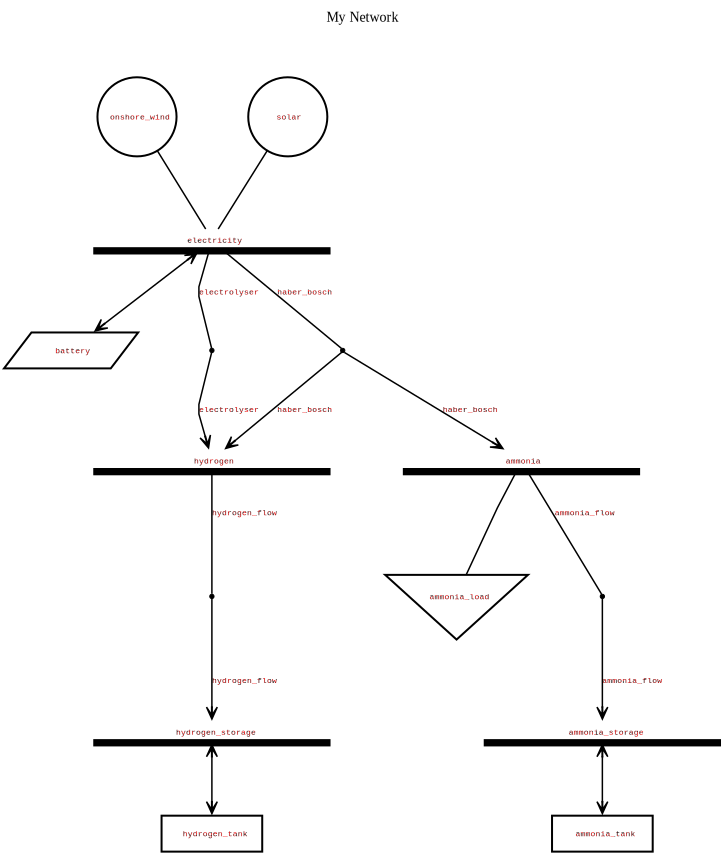

0

In [478]:
pypsatopo.generate(n)

In [480]:
# Solve network using cbc solver
n.optimize(pyomo=False, solver_name=solver)

Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
Index(['hydrogen_flow', 'ammonia_flow', 'electrolyser', 'haber_bosch'], dtype='object', name='Link')
Index(['hydrogen_tank', 'ammonia_tank'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'hydrogen_storage', 'ammonia',
       'ammonia_storage'],
      dtype='object', name='Bus')
Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
Index(['hydrogen_flow', 'ammonia_flow', 'electrolyser', 'haber_bosch'], dtype='object', name='Link')
Index(['hydrogen_tank', 'ammonia_tank'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'hydrogen_storage', 'ammonia',
       'ammonia_storage'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|████████████| 11/11 [00:00<00:00, 26.06it/s]
INFO:linopy.io: Writing time: 3.5s
INFO:linopy.solvers:

('ok', 'optimal')

In [481]:
n.stores_t.p

Store,hydrogen_tank,ammonia_tank
snapshot,,
2019-01-01 00:00:00,-0.000000,-0.00000
2019-01-01 01:00:00,0.000000,-1.48254
2019-01-01 02:00:00,-60.625740,-1.48254
2019-01-01 03:00:00,-90.166980,-1.48254
2019-01-01 04:00:00,-29.365157,-1.48254
...,...,...
2019-12-31 19:00:00,-81.060536,-1.48254
2019-12-31 20:00:00,23.700981,-1.48254
2019-12-31 21:00:00,-86.484453,2.96508


In [482]:
pd.concat([n.stores_t.e,n.stores_t.p],axis=1).head()


Store,hydrogen_tank,ammonia_tank,hydrogen_tank,ammonia_tank
snapshot,,,,
2019-01-01 00:00:00,-0.00000,-0.00000,-0.000000,-0.00000
2019-01-01 01:00:00,-0.00000,1.48254,0.000000,-1.48254
2019-01-01 02:00:00,60.62574,2.96508,-60.625740,-1.48254
2019-01-01 03:00:00,150.79272,4.44762,-90.166980,-1.48254
2019-01-01 04:00:00,180.15788,5.93016,-29.365157,-1.48254


In [483]:
n.generators.p_nom_opt

Generator
onshore_wind    1472.64410
solar            415.37468
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

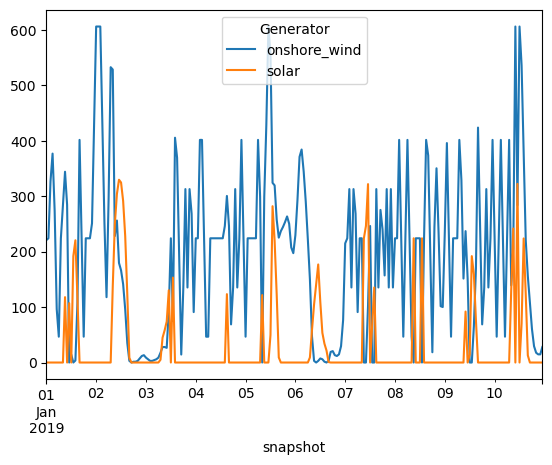

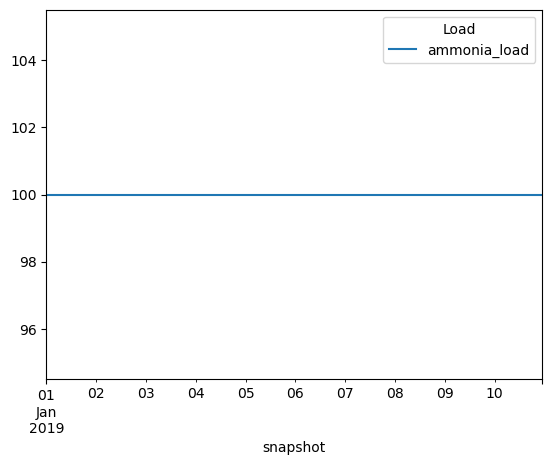

In [484]:
# Inspect the interaction of different power plants to supply loads
n.generators_t.p[:24*10].plot()

# Inspect the interaction of ammonia load to supply loads
n.loads_t.p[:24*10].plot()

<Axes: xlabel='snapshot'>

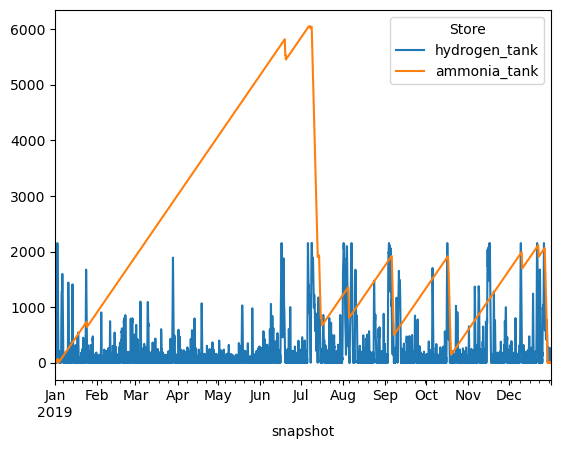

In [485]:
# Inspect the change of energy capacity [MWh] in hydrogen_tank store to supply loads
n.stores_t.e[:24*365].plot()

<Axes: xlabel='snapshot'>

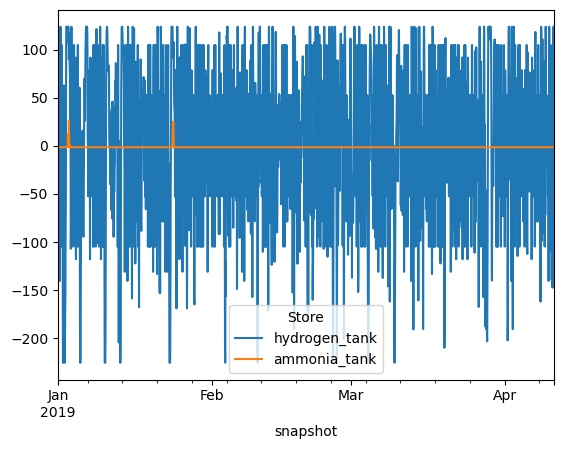

In [486]:
# Inspect the change of power [MW] in hydrogen_tank store to supply loads
n.stores_t.p[:24*100].plot()

<Axes: xlabel='snapshot'>

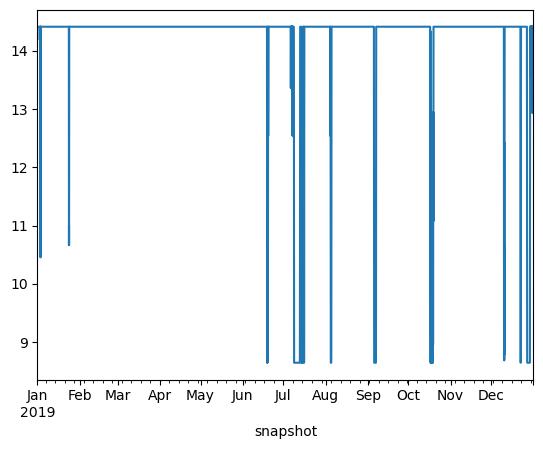

In [487]:
# Inspect the electrolysis input power
#n.links_t.p0["electrolyser"][:24*10].plot()

# Inspect the Haber Bosch input power
n.links_t.p0["haber_bosch"][:24*365].plot()

<Axes: xlabel='snapshot'>

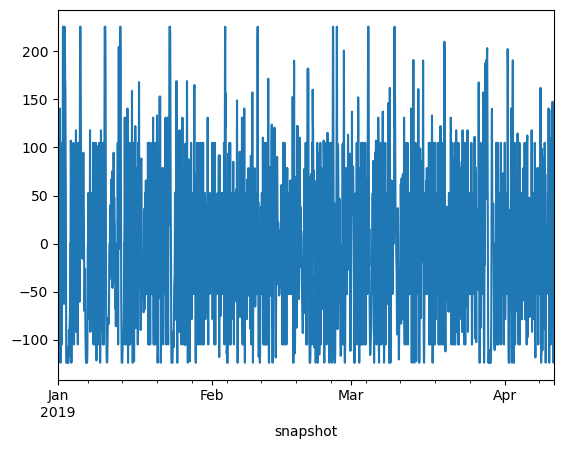

In [488]:
# Inspect the charging flow
n.links_t.p0["hydrogen_flow"][:24*100].plot()

<Axes: xlabel='snapshot'>

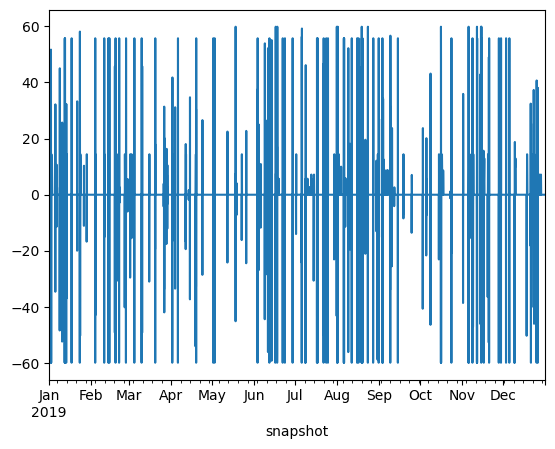

In [489]:
# Inspect the charging flow
n.storage_units_t.p["battery"][:24*365].plot()

<Axes: xlabel='snapshot'>

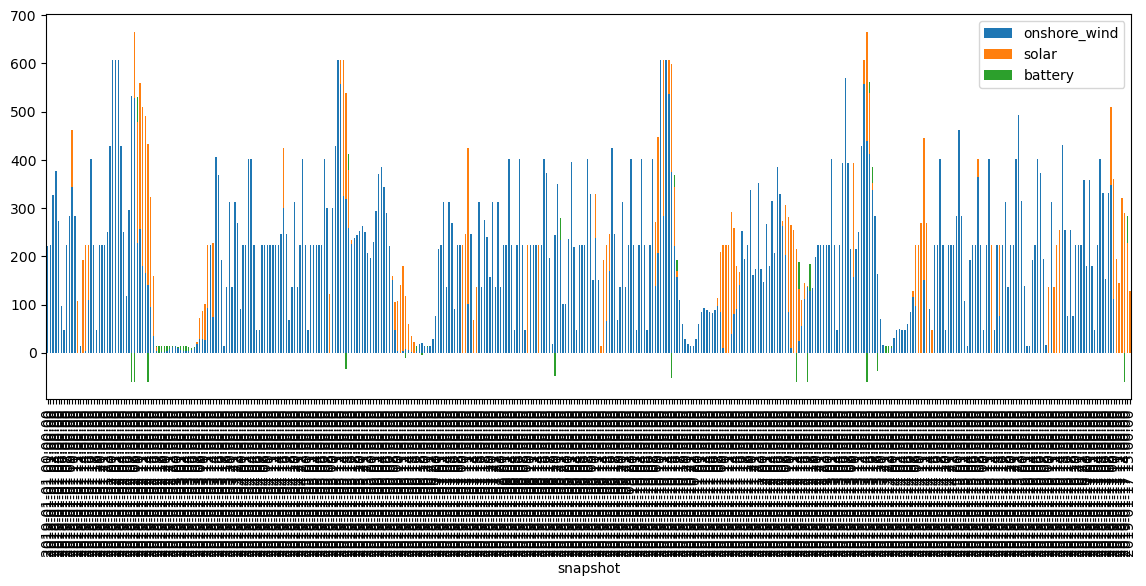

In [490]:
# Inspect storage interaction with other powerplants to supply loads
load = n.loads_t.p
pow_gen = n.generators_t.p
storage = n.storage_units_t.p
result = pd.concat([pow_gen, storage, load], axis=1)

plot = result.loc[
    :, ~result.columns.isin(["ammonia_load"])
]  # drop load and nuclear columns
plot.iloc[:400, :].plot(kind="bar", stacked=True, figsize=(14, 5))

In [491]:
n.statistics()

Optimal Capacity  Installed Capacity        Supply  \
Generator   solar                415.37468                 0.0  4.111107e+05   
            wind                1472.64410                 0.0  1.524519e+06   
Link        Electrolyser         591.87298                 0.0  1.068291e+06   
            Haber-Bosch           14.41052                 0.0  8.760000e+05   
            ammonia               39.11048                 0.0  2.477250e+04   
            hydrogen             225.44609                 0.0  4.957020e+05   
Load        -                      0.00000                 0.0  0.000000e+00   
StorageUnit -                     59.83771                 0.0  7.794196e+03   
Store       ammonia             6044.79710                 0.0  1.238625e+04   
            hydrogen            2152.26890                 0.0  2.478510e+05   

                            Withdrawal  Energy Balance  Transmission  \
Generator   solar         0.000000e+00    4.111107e+05       0.00000   
            wind          0.000000e+00    1.524519e+06       0.00000   
Link        Electrolyser  1.810662e+06   -7.423715e+05       0.00000   
            Haber-Bosch   1.192683e+06   -3.166828e+05       0.00000   
            ammonia       2.477250e+04    0.000000e+00       0.00037   
            hydrogen      4.957020e+05    0.000000e+00       0.00078   
Load        -             8.760000e+05   -8.760000e+05       0.00000   
StorageUnit -             8.369831e+03   -5.756351e+02       0.00000   
Store       ammonia       1.238625e+04   -3.700000e-04       0.00000   
            hydrogen      2.478510e+05   -7.800000e-04       0.00000   

                          Capacity Factor   Curtailment  Capital Expenditure  \
Generator   solar                0.112983  2.788299e+05         1.763269e+07   
            wind                 0.118176  3.082857e+06         8.078410e+07   
Link        Electrolyser         0.349225  0.000000e+00         2.908244e+04   
            Haber-Bosch          0.985391  0.000000e+00         6.294324e+06   
            ammonia              0.072306  0.000000e+00         0.000000e+00   
            hydrogen             0.251000  0.000000e+00         0.000000e+00   
Load        -                         NaN  0.000000e+00         0.000000e+00   
StorageUnit -                    0.030837  5.247540e+05         1.103621e+06   
Store       ammonia              0.371810  0.000000e+00         5.825083e+04   
            hydrogen             0.119979  0.000000e+00         1.091499e+07   

                          Operational Expenditure       Revenue  Market Value  
Generator   solar                    0.000000e+00  1.763269e+07     42.890355  
            wind                     0.000000e+00  8.078409e+07     52.989880  
Link        Electrolyser             0.000000e+00  2.908248e+04      0.027223  
            Haber-Bosch              9.505476e+06  1.579980e+07     18.036303  
            ammonia                  3.700000e-04  3.700000e-04           NaN  
            hydrogen                 7.800000e-04  7.800000e-04           NaN  
Load        -                        0.000000e+00 -1.263225e+08           NaN  
StorageUnit -                        0.000000e+00  1.103621e+06    141.594987  
Store       ammonia                 -3.700000e-04  5.825080e+04      4.702842  
            hydrogen                -7.800000e-04  1.091499e+07     44.038530

In [492]:
# Extract statistics
stats_df = n.statistics()
#stats_df.to_csv("/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LCOA.csv", index=False)
print(stats_df.index)  # Shows index labels

# Initialize a dictionary to store results
results = {}

# Sum total CAPEX
total_capex = stats_df["Capital Expenditure"].sum()
results["Total CAPEX"] = total_capex

# Sum total OPEX
total_opex = stats_df["Operational Expenditure"].sum()
results["Total OPEX"] = total_opex

# Ammonia output
value = stats_df.loc[("Link", "Haber-Bosch"), "Supply"]
MW_to_t_conversion = (1 / 5.2)
a_output = value  # Adjusted as needed
results["Total Ammonia Output"] = a_output

# Levelized Cost of Ammonia (LCOA)
LCOA = ((total_capex + total_opex) / a_output) / MW_to_t_conversion
results["Total LCOA (USD/t)"] = LCOA

# Convert dictionary to DataFrame
df_results = pd.DataFrame(list(results.items()), columns=["Description", "Value"])

# Define the CSV file path
csv_file_path = "/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LiNi_Chaoyang_LCOA_2.csv"

# Open file and write both DataFrames in a structured way
with open(csv_file_path, "w", encoding="utf-8-sig") as f:
    f.write("### Statistics Data ###\n")
    stats_df.to_csv(f, index=True)
    
    f.write("\n### Results Summary ###\n")
    df_results.to_csv(f, index=False)

# Provide file path for download
csv_file_path

MultiIndex([(  'Generator',        'solar'),
            (  'Generator',         'wind'),
            (       'Link', 'Electrolyser'),
            (       'Link',  'Haber-Bosch'),
            (       'Link',      'ammonia'),
            (       'Link',     'hydrogen'),
            (       'Load',            '-'),
            ('StorageUnit',            '-'),
            (      'Store',      'ammonia'),
            (      'Store',     'hydrogen')],
           )


'/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LiNi_Chaoyang_LCOA_2.csv'

In [ ]:
# Exporting Ammonia network
n.export_to_netcdf("/Users/philip/Desktop/AGORA/China PyPSA LCOX/2024-10-PyPSA-H2-Training/results/ammonia1-1.nc")

In [ ]:
"""
# notes
1. update numbers
1.1. update solar #check
1.2. update on_wind #check
1.3. update electrolyser #check (not sure if satisfactory, ramp up?)
1.4. update haber_bosch #check (not sure if satisfactory, ramp up?)
1.5. update hydrogen storage #check
1.6. update ammonia tank ? 
1.7. update battery storage #check (better data available?) 

2. create new wind and solar profiles for China #check
2.1 ninja for wind
2.2 solar atlas for solar?

# questions: 
1. Should there be a curtailment option for solar and wind, or an option to sell excess power to the power market? 
1.1 I am raising this question, as the electrolysis is primarily only running when solar energy is available, instead of more constantly, which seams the intuitive way, given that RES is so cheap?
2. both electrolyser and haber-bosch currently behave according to the intermittance of wind (and solar but less so) 
3. The battery seems to not connect, something seems wrong here. I do wonder if the unit for the capex shouldnt be MWh and not MW? 
4. How do I now determine the LCOA of the whole model? I haven't quite understood how that works.
"""

In [ ]:
#References: 
#1- Agora Energiewende (2024). PyPSA Agora H2 Training. https://github.com/agoenergy/pypsa-agora-h2-training/tree/main
#2- Agora Energy Transition China (2025). China green LCO-X dataset. 
#3- wind and solar profiles: https://www.renewables.ninja/
#4 - Bodke, N., Pedersen, T. Andresen, G. (2021). Optimal Scheduling of Flexible Power-to-X Technologies in the Day-ahead Electricity Market. https://arxiv.org/pdf/2110.09800 